In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate
# Deep Learning
#import tensorflow as tf

In [46]:
def add_data_info():
    df1 = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-m-points-from-2017.csv', encoding= 'unicode_escape', low_memory=False)
    df2 = pd.read_csv('raw_data/charting-m-matches.csv', encoding= 'unicode_escape', low_memory=False)
    
    #get separated values from m-matches list of games - based on matchid
    df = pd.merge(df1,df2[['match_id','Date','Tournament','Round','Surface','Player 1','Player 2']], on=['match_id'], how='left')
    
    #add the condition of "Grand Slam" - 5 or 3 sets
    conditions = df['Tournament'].isin(["Wimbledon", "Australian Open", "US Open", "Roland Garros"])
    values = [1,0]

    # Create a new column  based on the conditions and values
    df['Grand Slam'] = pd.Series(pd.NA)
    df.loc[conditions, 'Grand Slam'] = values[0]
    df.loc[~conditions, 'Grand Slam'] = values[1]
    
    # save the original dataset with enriched data for future features
    df.to_csv('raw_data/charting-m-points-from-2017-enriched.csv', index=False)

In [47]:
def filter_player(df,opponent):
    
    # Read the dataset into a pandas DataFrame - from enriched file
    df = pd.read_csv(df, encoding= 'unicode_escape', low_memory=False)
    
    ## filtra pelo  oponente
    df = df[(df["Player 1"].str.contains(opponent)) | (df["Player 2"].str.contains(opponent))].copy()
    
    ##define se está sacando e se ganhou o ponto
    df['i_serve'] = np.where(((df['Svr'] == 1) & (df['Player 1'] == opponent )) | ((df['Svr'] == 2) & (df['Player 2'] == opponent)), 0, 1)
    df['i_win'] = np.where(((df['isSvrWinner'] == df['i_serve'])), 1, 0)
    df['is_second_service'] = np.where(((df['2nd'].isnull())), 0, 1)
    
    ## direção do saque
    # primeiro caractere do segundo saque
    df['dir_srv'] = df.loc[:, '2nd'].str[0]
    ## completa com o primeiro caractere do primeiro saque quando ele entrou
    df['dir_srv'].fillna(df.loc[:, '1st'].str[0], inplace=True)

    
    ##reseta o indice
    df.reset_index(inplace=True)
    
    ## salva arquivo e retorna dataset da funcao
    csv_file = "raw_data/" + opponent + "_points.csv"
    df.to_csv(csv_file, index=False)
    return df

In [48]:
meaning_char = pd.read_csv('https://raw.githubusercontent.com/eduardoscovino/tennis-analytics/master/code_map.csv',
                           encoding= 'unicode_escape', sep=';')

In [49]:
add_data_info()

In [139]:
df = filter_player('raw_data/charting-m-points-from-2017-enriched.csv','Novak Djokovic')

In [140]:
## serve direction encode 
df = df[df['dir_srv'].isin(['4','5','6'])]

## to numeric for rallyCount and serve direction
df['rallyCount']=pd.to_numeric(df['rallyCount'])
df['dir_srv']=pd.to_numeric(df['dir_srv'])

In [141]:
#Spliting Serve and Return
df['rally_desc'] = df.loc[:, '2nd']
df['rally_desc'].fillna(df.loc[:, '1st'], inplace=True)

##df['Serve'] = df.loc[:, 'rally_desc'].str[0:1]

df['rally_desc'] = df['rally_desc'].str[1:]

sc = np.array(meaning_char[~meaning_char['code'].isin(['f', 'b', 'r', 's', 'v', 'l', 'o', 'z', 'p', 'u', 'y', 'h', 'i', 'j', 'k','m', '1', '2', '3', '7', '8', '9'])]['code'])

#Spliting every shot
df['rally_desc'] = df['rally_desc'].apply(lambda x: ''.join([c for c in x if c not in sc]))
df['rally_desc'] = df['rally_desc'].str.replace('f',' f').str.replace('b',' b').str.replace('s',' s').str.replace('r',' r').str.replace('v',' v').str.replace('l',' l').str.replace('o',' o').str.replace('z',' z').str.replace('p',' p').str.replace('u',' u').str.replace('y',' y').str.replace('h',' h').str.replace('i',' i').str.replace('j',' j').str.replace('k',' k').str.replace('m',' m').str.replace('!','').str.replace('+','').str.replace(';','').str.replace('^','').str.replace('C','')
df['rally_desc'] = df['rally_desc'].map(lambda x: x.lstrip(' ').rstrip(' '))

df['rally_tratada'] = (df['rallyCount']/2).apply(np.floor)
df['rally_tratada'] = df['rally_tratada'].astype(np.int64)

/var/folders/kk/0r0_hyfd673456ly0hptrbsc0000gn/T/ipykernel_2641/2078486838.py:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['rally_desc'] = df['rally_desc'].str.replace('f',' f').str.replace('b',' b').str.replace('s',' s').str.replace('r',' r').str.replace('v',' v').str.replace('l',' l').str.replace('o',' o').str.replace('z',' z').str.replace('p',' p').str.replace('u',' u').str.replace('y',' y').str.replace('h',' h').str.replace('i',' i').str.replace('j',' j').str.replace('k',' k').str.replace('m',' m').str.replace('!','').str.replace('+','').str.replace(';','').str.replace('^','').str.replace('C','')


### Adição da coluna how_ended

In [142]:
# df['end']
df['how_ended'] = df.loc[:, '2nd'].str[-1]
df['how_ended'].fillna(df.loc[:, '1st'].str[-1], inplace=True)

df.head()

,index,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts,Gm#,TbSet,TB?,TBpt,Svr,Ret,Serving,1st,2nd,Notes,1stSV,2ndSV,1stIn,2ndIn,isAce,isUnret,isRallyWinner,isForced,isUnforced,isDouble,PtWinner,isSvrWinner,rallyCount,Date,Tournament,Round,Surface,Player 1,Player 2,Grand Slam,i_serve,i_win,is_second_service,dir_srv,rally_desc,rally_tratada,how_ended
0,637,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,1,0,0,0,0,0-0,1 (1),1,0,NaN,1,2,ND,4n,4f18f3s2f1f3b3n@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,2,0,6,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,1,1,4,f18 f3 s2 f1 f3 b3,3,@
1,638,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,2,0,0,0,0,0-15,1 (2),1,0,NaN,1,2,ND,4n,6f2n#,NaN,0,0.0,0,1.0,False,False,False,True,False,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,6,f2,0,#
2,639,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,3,0,0,0,0,15-15,1 (3),1,0,NaN,1,2,ND,4*,NaN,Failed Ruud challenge,0,NaN,1,NaN,True,False,False,False,False,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,,0,*
3,640,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,4,0,0,0,0,30-15,1 (4),1,0,NaN,1,2,ND,4n,5b3n@,NaN,0,0.0,0,1.0,False,False,False,False,True,False,1,1,1,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,1,5,b3,0,@
4,641,20221120-M-Tour_Finals-F-Novak_Djokovic-Casper...,5,0,0,0,0,40-15,1 (5),1,0,NaN,1,2,ND,4r28f1r2f3b3f2f1f1f3b3b3b1r2n#,NaN,NaN,0,NaN,1,NaN,False,False,False,True,False,False,1,1,13,20221120,Tour Finals,F,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,4,r28 f1 r2 f3 b3 f2 f1 f1 f3 b3 b3 b1 r2,6,#


In [143]:
# vamos entender melhor isso aqui

df['how_ended'].value_counts()

#    6264
*    6054
@    5820
d     267
n     249
w      66
x      14
C      13
;       4
Name: how_ended, dtype: int64

In [144]:
df['isUnforced'] = df['isUnforced'].replace({True: 1, False: 0})
df['isForced'] = df['isForced'].replace({True: 1, False: 0})
df['serve_return'] = df['rally_desc'].map(lambda x: x.split(' ')).str[0]

## Dataset finalizado - filtrando i_win = 1 / i_serve = 0 ##

In [145]:
df['i_win'].value_counts()

0    9882
1    8869
Name: i_win, dtype: int64

In [156]:
df_receive = df[df['i_serve']==0]
df_receive = df_receive[df_receive['serve_return']!=""]

In [157]:
percentage_win = df_receive.groupby(['i_win']).size() / len(df_receive) * 100
percentage_win  = percentage_win.reset_index(name='percentage')
percentage_win

,i_win,percentage
0,0,67.017589
1,1,32.982411


In [159]:
serve_return_stats = df_receive.groupby(['serve_return', 'i_win']).size() / len(df_receive) * 100
serve_return_stats = serve_return_stats.reset_index(name='percentage')

top5_serve_returns = serve_return_stats.groupby('serve_return').apply(lambda x: x.nlargest(5, 'percentage')).reset_index(drop=True)

top5_serve_returns

,serve_return,i_win,percentage
0,b,0,78
1,b,1,12
2,b1,0,107
3,b1,1,5
4,b17,0,35
...,...,...,...
128,s39,1,25
129,u37,0,1
130,y27,0,1
131,y27,1,1


In [93]:
df = df[df['i_win']==1]
df = df[df['i_serve']==0]
df = df[df['serve_return'] != ""]

In [94]:
df['serve_return'].nunique()

59

In [125]:
df['serve_return'].value_counts(normalize=True)

f28    0.120280
b28    0.096925
b38    0.075127
f29    0.070845
f38    0.062281
b29    0.059167
f18    0.052939
b37    0.035812
f27    0.033865
b27    0.032698
f39    0.032308
b18    0.029194
f2     0.024523
b2     0.023745
b39    0.020631
f37    0.020241
f19    0.019852
s28    0.019463
f17    0.015181
s38    0.014013
b19    0.014013
s37    0.010899
s29    0.010510
s39    0.009731
b17    0.009731
b3     0.008953
f1     0.007007
r28    0.006617
f      0.006617
s27    0.006228
f3     0.005839
r29    0.005450
r27    0.004671
b      0.004671
r37    0.004282
r39    0.002725
r18    0.002336
r17    0.002336
r38    0.002336
b1     0.001946
r2     0.001557
s19    0.001557
s18    0.001168
m2     0.001168
s17    0.001168
r19    0.001168
s2     0.000779
s3     0.000779
m3     0.000779
y27    0.000389
m1     0.000389
s      0.000389
r3     0.000389
l17    0.000389
r      0.000389
m17    0.000389
q28    0.000389
s1     0.000389
b8     0.000389
Name: serve_return, dtype: float64

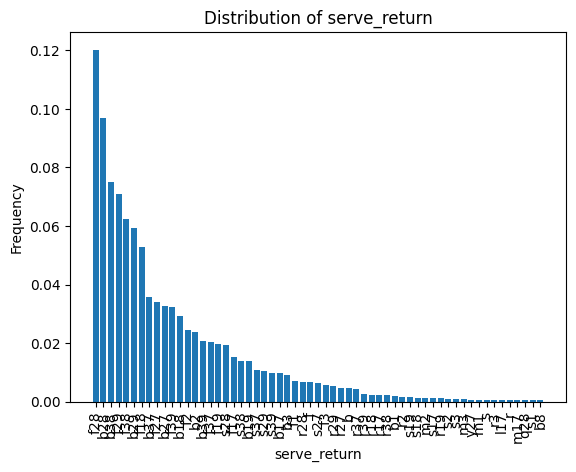

In [127]:
serve_return_column = df["serve_return"]
value_counts = serve_return_column.value_counts(normalize=True)
total_points = df["serve_return"].sum()

plt.bar(value_counts.index, value_counts.values )
#plt.hist(value_counts, histtype='bar', rwidth=0.8)
plt.xlabel("serve_return")
plt.ylabel("Frequency")
plt.title("Distribution of serve_return")
plt.xticks(rotation=90)
plt.show()

In [138]:
percentage_by_serve_return = df.groupby(['dir_srv', 'serve_return']).size() / len(df) * 100
percentage_by_serve_return = percentage_by_serve_return.reset_index(name='percentage')

top5_serve_returns = percentage_by_serve_return.groupby('dir_srv').apply(lambda x: x.nlargest(3, 'percentage')).reset_index(drop=True)

top5_serve_returns

,dir_srv,serve_return,percentage
0,4,f28,5.138186
1,4,b38,4.087193
2,4,f18,3.892565
3,5,b28,3.114052
4,5,b38,1.829506
5,5,f28,1.712729
6,6,f28,5.177112
7,6,b28,3.347606
8,6,f38,3.191903


In [137]:
percentage_serve_direction = df.groupby(['dir_srv']).size() / len(df) * 100
percentage_serve_direction = percentage_serve_direction.reset_index(name='percentage')
percentage_serve_direction

,dir_srv,percentage
0,4,41.300117
1,5,20.903075
2,6,37.796808


## Geração das features

In [97]:
features = ['Surface',
            'Round',
            'Grand Slam',
            'is_second_service',
            'dir_srv',
            'rally_tratada',
            'isUnforced',
            'isForced',
            "how_ended"
            ]
X = df[features]
y = df['serve_return']

In [100]:
feat_categorical = ['Surface','Round','dir_srv','how_ended']

In [101]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2569 entries, 0 to 19319
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Surface            2569 non-null   object
 1   Round              2569 non-null   object
 2   Grand Slam         2569 non-null   int64 
 3   is_second_service  2569 non-null   int64 
 4   dir_srv            2569 non-null   int64 
 5   rally_tratada      2569 non-null   int64 
 6   isUnforced         2569 non-null   int64 
 7   isForced           2569 non-null   int64 
 8   how_ended          2569 non-null   object
dtypes: int64(6), object(3)
memory usage: 200.7+ KB


## separação - treino, teste e validação

In [103]:
from sklearn.model_selection import train_test_split

# Train-Test Split - ## parametro stratify ###
train, test = train_test_split(df, test_size=0.3)

# Train-Val Split
train, val = train_test_split(train, test_size=0.3)


In [104]:
## Separating features and target in the Train, Val and Test Set

X_train = train[features]
y_train = train['i_win']

X_val = val[features]
y_val = val['i_win']

X_test = test[features]
y_test = test['i_win']

In [105]:
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

1258 train examples
540 validation examples
771 test examples


## Inicio do modelo - pre processamento e encoder

In [107]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn import set_config
set_config(display="diagram")

In [108]:
preproc = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_exclude=["object"])),
    (OneHotEncoder(handle_unknown="ignore", sparse_output=False), make_column_selector(dtype_include=["object"]))
)

preproc

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1444cfac0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1444ce560>)])

In [109]:
preproc.fit_transform(X_train).shape

(1258, 23)

In [110]:
X_train_preproc = preproc.fit_transform(X_train)
X_val_preproc = preproc.transform(X_val)
X_test_preproc = preproc.transform(X_test)

## Definição do modelo

In [111]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

In [112]:
model = Sequential()

# 1. Architecture
model.add(layers.Dense(32, activation='relu', input_shape=(X_train_preproc.shape[-1],)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(18, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

# 2. Compiling
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [113]:
# 3. Training
es = EarlyStopping(monitor = 'val_accuracy',
                   patience = 10,
                   verbose = 0,
                   restore_best_weights = True)

history = model.fit(X_train_preproc,
                   y_train,
                   validation_data = (X_val_preproc, y_val),
                   batch_size = 64,
                   epochs = 500,
                   callbacks = [es], 
                   verbose = 1)

Epoch 1/500


2023-06-10 16:17:15.278481: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


20/20 [==============================] - 0s 5ms/step - loss: 0.6029 - accuracy: 0.7242 - val_loss: 0.4837 - val_accuracy: 1.0000
Epoch 2/500
20/20 [==============================] - 0s 925us/step - loss: 0.3607 - accuracy: 0.9769 - val_loss: 0.2168 - val_accuracy: 1.0000
Epoch 3/500
20/20 [==============================] - 0s 955us/step - loss: 0.1674 - accuracy: 0.9984 - val_loss: 0.0653 - val_accuracy: 1.0000
Epoch 4/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0757 - accuracy: 0.9992 - val_loss: 0.0189 - val_accuracy: 1.0000
Epoch 5/500
20/20 [==============================] - 0s 933us/step - loss: 0.0382 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 6/500
20/20 [==============================] - 0s 951us/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 7/500
20/20 [==============================] - 0s 938us/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 8/500
20/

## Resultado final / evaluate

In [114]:
res = model.evaluate(X_test_preproc, y_test)
print(f"accuracy = {res[1]:.3f}")

25/25 [==============================] - 0s 411us/step - loss: 0.4812 - accuracy: 1.0000
accuracy = 1.000


In [115]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                768       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                495       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_2 (Dense)             (None, 18)                288       
                                                                 
 dropout_2 (Dropout)         (None, 18)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

## Verificação loss/accuracy - overfit / underfit

In [116]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

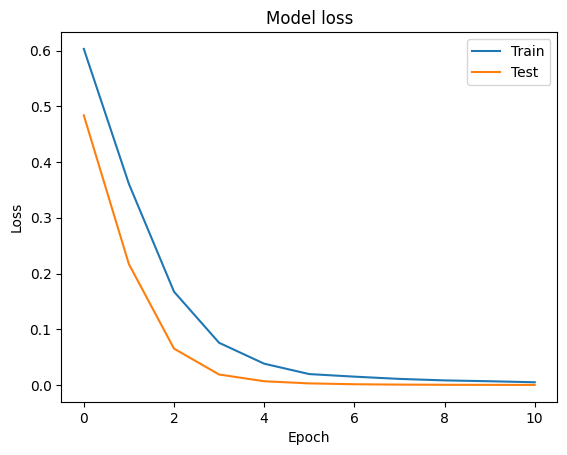

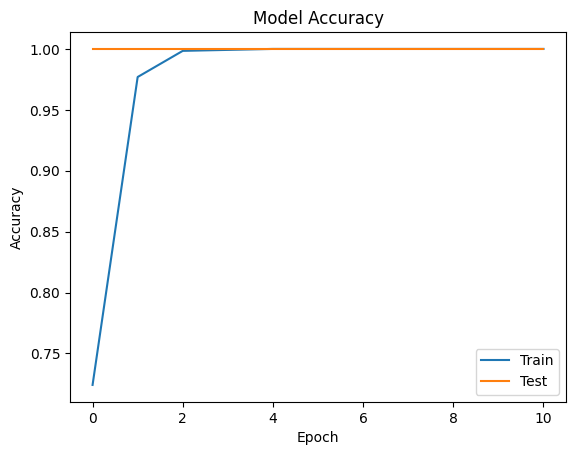

In [117]:
plot_loss_accuracy(history)

In [118]:
model.predict(X_test_preproc)

25/25 [==============================] - 0s 284us/step


array([[0.69861406],
       [0.6231068 ],
       [0.64668983],
       [0.6214006 ],
       [0.5486802 ],
       [0.5634547 ],
       [0.55597603],
       [0.63094366],
       [0.6544959 ],
       [0.6195272 ],
       [0.58207345],
       [0.6018773 ],
       [0.68248457],
       [0.5625576 ],
       [0.5877557 ],
       [0.70760334],
       [0.6755782 ],
       [0.65612876],
       [0.57733214],
       [0.52936226],
       [0.69159377],
       [0.6801209 ],
       [0.599948  ],
       [0.62191486],
       [0.62938404],
       [0.6434453 ],
       [0.6775298 ],
       [0.6443629 ],
       [0.61501926],
       [0.6169034 ],
       [0.6539784 ],
       [0.66555685],
       [0.5841651 ],
       [0.6794987 ],
       [0.67444676],
       [0.6697195 ],
       [0.6197381 ],
       [0.658041  ],
       [0.6503556 ],
       [0.63365006],
       [0.5632101 ],
       [0.5733551 ],
       [0.6607158 ],
       [0.6820715 ],
       [0.52462614],
       [0.5735711 ],
       [0.6019183 ],
       [0.656